In [1]:
import geopandas as gpd
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
from rasterio.enums import Resampling 
from rasterio.mask import mask
from matplotlib.colors import LinearSegmentedColormap, Normalize
import numpy as np
from scipy.stats import skew, kurtosis
import seaborn as sns
from plot_functions import plot_boxplots, plot_distributions

Original shape: 33600 x 86400
Downsampled shape: (3360, 8640)


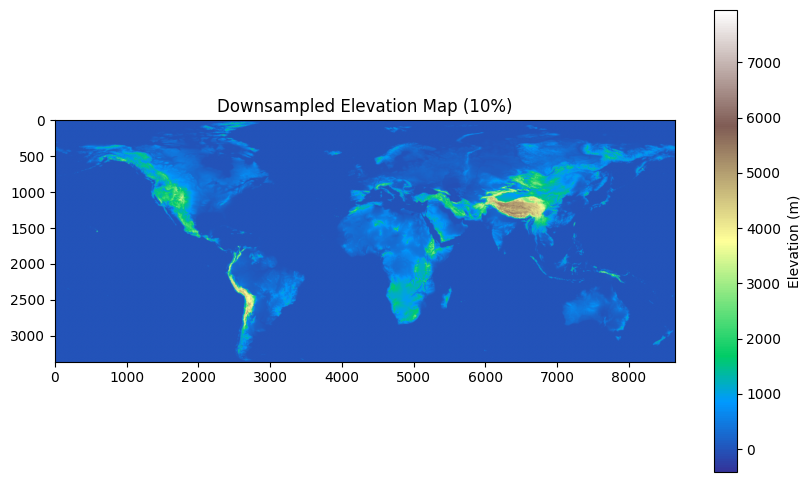

In [2]:

# Path to the folder (the folder itself is the "dataset")
raster_file = "DATA/Elevation/be15_grd/w001000.adf"


with rasterio.open(raster_file) as src:
    print("Original shape:", src.height, "x", src.width)
    scale = 0.1
    new_height = int(src.height * scale)
    new_width = int(src.width * scale)
    elevation = src.read(
        1,
        out_shape=(1, new_height, new_width),
        resampling=Resampling.average
    )
    transform = src.transform * src.transform.scale(
        (src.width / new_width),
        (src.height / new_height)
    )

print("Downsampled shape:", elevation.shape)
plt.figure(figsize=(10, 6))
plt.imshow(elevation, cmap="terrain")
plt.colorbar(label="Elevation (m)")
plt.title("Downsampled Elevation Map (10%)")
plt.show()



In [3]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

# -----------------------------
# Paths
# -----------------------------
shapefile_path = "countries_data/ne_110m_admin_0_countries.shp"
raster_path = "DATA/Elevation/be15_grd/be15_grd/w001000.adf"
output_csv = "./elevation_2024.csv"

# -----------------------------
# Load country shapes
# -----------------------------
world = gpd.read_file(shapefile_path).to_crs("EPSG:4326")
world["ADMIN"] = world["ADMIN"].str.strip().str.lower()

algeria = world[world["ADMIN"].isin(["algeria", "tunisia"])]

if algeria.empty :
    raise ValueError("Could not find Algeria or Tunisia in the shapefile.")

# -----------------------------
# Clip raster function
# -----------------------------
def clip_raster(raster_path, country_gdf):
    with rasterio.open(raster_path) as src:
        country_geom = [country_gdf.geometry.unary_union] # Merge all geometries
        # Mask only the country area to save memory
        clipped_image, clipped_transform = mask(src, country_geom, crop=True)
        clipped_meta = src.meta.copy()
        clipped_meta.update({
            "height": clipped_image.shape[1],
            "width": clipped_image.shape[2],
            "transform": clipped_transform
        })
    return clipped_image[0], clipped_meta



# -----------------------------
# Memory-safe clipping
# -----------------------------
algeria_clip, _ = clip_raster(raster_path, algeria)
# -----------------------------
# Use original raster's global min/max for consistent colors
# -----------------------------
with rasterio.open(raster_path) as src:
    # Read in a downsampled version to get min/max without MemoryError
    print(src.meta) 
    factor = 10  # downsample factor for stats
    out_shape = (1, src.height // factor, src.width // factor)
    data_small = src.read(1, out_shape=out_shape, masked=True)
    global_min = data_small.min()
    global_max = data_small.max()
    nodata = src.nodata


norm = Normalize(vmin=global_min, vmax=global_max)

# -----------------------------
# Plot function
# -----------------------------
def plot_raster(data, title):
    plt.figure(figsize=(6,6))
    plt.imshow(data, cmap= "terrain" , norm=norm)
    plt.title(title, fontsize=13)
    plt.colorbar(label="Elevation (m)")
    plt.axis("off")
    plt.show()

# -----------------------------
# Plot clipped maps
# -----------------------------
plot_raster(algeria_clip, "GMTED2010 Elevation — Algeria")



RasterioIOError: DATA/Elevation/be15_grd/be15_grd/w001000.adf: No such file or directory

In [ ]:

print(data_small.shape)     # dimensions
print(data_small.min(), data_small.max(), data_small.mean())  # statistiques simples
# Aplatir en 1D pour les stats
values = data_small.flatten()
values2 = values[values != nodata]  # enlever les valeurs manquantes

(3360, 8640)
-412 8517 179.9325073715829


In [ ]:
print("Nombre de pixels :", len(values))
print("Min :", values.min())
print("Max :", values.max())
print("Moyenne :", values.mean())
print("Médiane :", np.median(values))
print("Écart-type :", values.std())
print("Skewness :", skew(values2))
print("Kurtosis :", kurtosis(values2))


Nombre de pixels : 29030400
Min : -412
Max : 8517
Moyenne : 179.9325073715829
Médiane : 0.0


C:\Users\MELISSA\AppData\Roaming\Python\Python310\site-packages\numpy\_core\fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Écart-type : 517.9535727055678
Skewness : 5.360572648182172
Kurtosis : 37.55134915811674


In [ ]:
missing_count = np.sum(data_small == nodata)
print("Valeurs manquantes :", missing_count)

Valeurs manquantes : 0


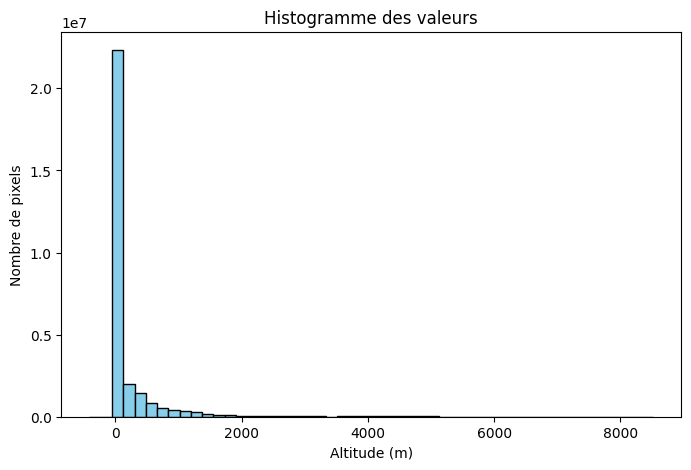

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(values, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogramme des valeurs")
plt.xlabel("Altitude (m)")
plt.ylabel("Nombre de pixels")
plt.show()


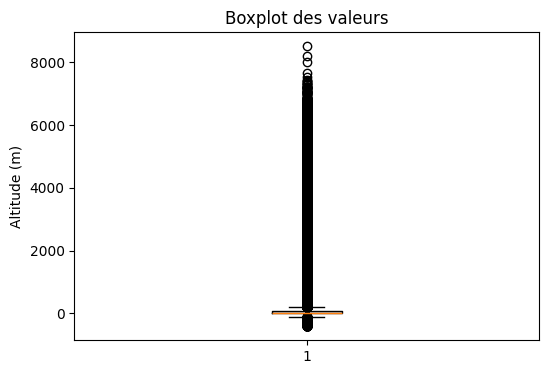

In [ ]:
plt.figure(figsize=(6,4))
plt.boxplot(values, vert=True)
plt.title("Boxplot des valeurs")
plt.ylabel("Altitude (m)")
plt.show()


In [ ]:
Q1 = np.percentile(values, 25)
Q3 = np.percentile(values, 75)
IQR = Q3 - Q1

outliers = values[(values < Q1 - 1.5*IQR) | (values > Q3 + 1.5*IQR)]
print("Nombre d'outliers :", len(outliers))
print("Exemples :", outliers[:10])


C:\Users\MELISSA\AppData\Roaming\Python\Python310\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


Nombre d'outliers : 5632190
Exemples : [302 245 320 311 333 339 318 257 245 283]
